# Entraînement et Sélection du Meilleur Modèle

Ce notebook est la deuxième étape de notre projet. Son but est de :
1. Charger les données préalablement traitées par le notebook `data_preprocessing.ipynb` depuis **PostgreSQL**.
2. Entraîner plusieurs modèles de classification (Régression Logistique, Random Forest, etc.).
3. Évaluer et comparer leurs performances sur un jeu de test.
4. Sélectionner automatiquement le meilleur modèle et le sauvegarder dans un fichier `.joblib` pour une utilisation future.

## 1. Imports et Chargement de l'Environnement

In [1]:
import pandas as pd
import os
import joblib
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score

load_dotenv()
print("Librairies importées et variables d'environnement chargées.")

Librairies importées et variables d'environnement chargées.


## 2. Chargement des Données Traitées depuis PostgreSQL

In [2]:
MODELS_DIR = '../models'
TARGET_COL = 'winner_encoded' # Le nom de colonne est maintenant en minuscules

pg_user = os.getenv("PG_USER")
pg_password = os.getenv("PG_PASSWORD")
pg_host = os.getenv("PG_HOST")
pg_port = os.getenv("PG_PORT")
pg_dbname = os.getenv("PG_DBNAME")

if not all([pg_user, pg_password, pg_host, pg_port, pg_dbname]):
    raise ValueError("Fichier .env incomplet. Vérifiez les variables PG_USER, PG_PASSWORD, etc.")

db_url = f"postgresql+psycopg2://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_dbname}"
engine = create_engine(db_url)

print("Chargement des données traitées depuis PostgreSQL...")
try:
    train_df = pd.read_sql_table('processed_train_data', engine)
    test_df = pd.read_sql_table('processed_test_data', engine)
    print(f"Données chargées : {len(train_df)} lignes d'entraînement et {len(test_df)} lignes de test.")

    print(f"Colonnes disponibles : {list(train_df.columns)}")

    if train_df.isnull().sum().sum() > 0 or test_df.isnull().sum().sum() > 0:
        raise ValueError("Des valeurs NaN ont été trouvées. Veuillez ré-exécuter le notebook 'data_preprocessing.ipynb'.")
    print("✅ Aucune valeur NaN détectée dans les données chargées.")
except Exception as e:
    print(f"❌ Erreur lors du chargement des données : {e}")

Chargement des données traitées depuis PostgreSQL...
Données chargées : 652 lignes d'entraînement et 94 lignes de test.
Colonnes disponibles : ['number_of_victims', 'immigration_rate', 'poverty_rate', 'unemployment_rate', 'department_code_01', 'department_code_02', 'department_code_03', 'department_code_04', 'department_code_05', 'department_code_06', 'department_code_07', 'department_code_08', 'department_code_09', 'department_code_10', 'department_code_11', 'department_code_12', 'department_code_13', 'department_code_14', 'department_code_15', 'department_code_16', 'department_code_17', 'department_code_18', 'department_code_19', 'department_code_21', 'department_code_22', 'department_code_23', 'department_code_24', 'department_code_25', 'department_code_26', 'department_code_27', 'department_code_28', 'department_code_29', 'department_code_30', 'department_code_31', 'department_code_32', 'department_code_33', 'department_code_34', 'department_code_35', 'department_code_36', 'departm

## 3. Séparation des Features (X) et de la Cible (y)

In [3]:
print("\nSéparation des features et de la cible...")
X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL]
X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]
print("✅ Terminé.")


Séparation des features et de la cible...
✅ Terminé.


## 4. Entraînement et Évaluation de Plusieurs Modèles

In [4]:
print("--- Entraînement et Évaluation des Modèles ---")
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nEntraînement de {name}...")
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    
    results[name] = {'model': model, 'accuracy': accuracy, 'precision': precision}
    
    print(f"✅ {name} -> Accuracy: {accuracy:.4f}, Weighted Precision: {precision:.4f}")

--- Entraînement et Évaluation des Modèles ---

Entraînement de Logistic Regression...
✅ Logistic Regression -> Accuracy: 0.2979, Weighted Precision: 0.6213

Entraînement de Random Forest...


✅ Random Forest -> Accuracy: 0.4894, Weighted Precision: 0.6634

Entraînement de Decision Tree...


✅ Decision Tree -> Accuracy: 0.4468, Weighted Precision: 0.6025

Entraînement de SVM...
✅ SVM -> Accuracy: 0.2340, Weighted Precision: 0.6298


## 5. Comparaison Visuelle des Performances

/tmp/ipykernel_42/1871552139.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='viridis')


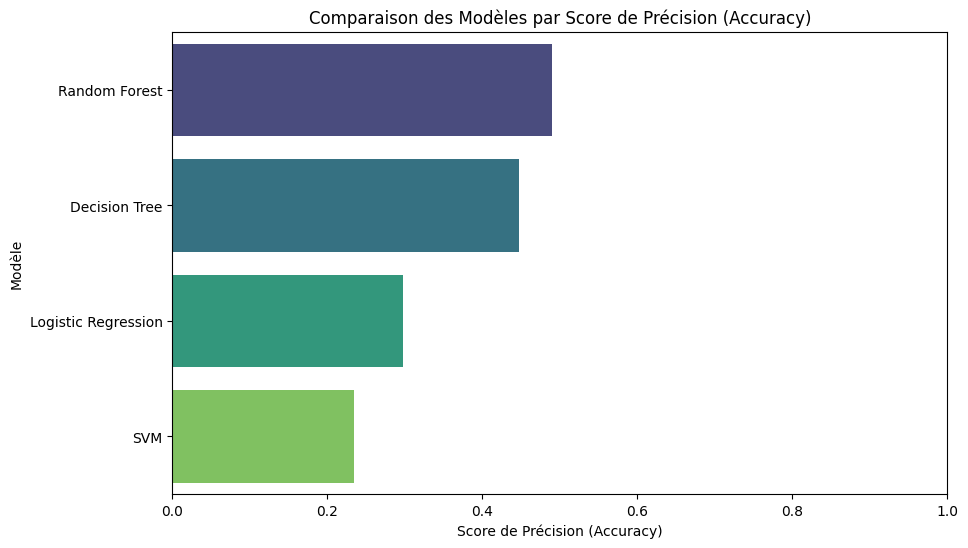


--- Résumé des Performances ---
                 Model  Accuracy
0        Random Forest  0.489362
1        Decision Tree  0.446809
2  Logistic Regression  0.297872
3                  SVM  0.234043


In [5]:
accuracy_df = pd.DataFrame([
    {'Model': name, 'Accuracy': res['accuracy']}
    for name, res in results.items()
]).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette='viridis')
plt.title('Comparaison des Modèles par Score de Précision (Accuracy)')
plt.xlabel('Score de Précision (Accuracy)')
plt.ylabel('Modèle')
plt.xlim(0, 1.0)
plt.show()

print("\n--- Résumé des Performances ---")
print(accuracy_df)

## 6. Sélection et Sauvegarde du Meilleur Modèle

In [6]:
best_model_name = accuracy_df.loc[0, 'Model']
best_model_object = results[best_model_name]['model']
best_model_accuracy = accuracy_df.loc[0, 'Accuracy']

print(f"\n🏆 Meilleur modèle sélectionné : '{best_model_name}' avec une précision de {best_model_accuracy:.4f}.")

os.makedirs(MODELS_DIR, exist_ok=True)

model_filename = f"{best_model_name.lower().replace(' ', '_')}_predictor.joblib"
model_path = os.path.join(MODELS_DIR, model_filename)

joblib.dump(best_model_object, model_path)

print(f"✅ Meilleur modèle sauvegardé ici : {model_path}")


🏆 Meilleur modèle sélectionné : 'Random Forest' avec une précision de 0.4894.


✅ Meilleur modèle sauvegardé ici : ../models/random_forest_predictor.joblib


## 7. Fermeture de la Connexion

In [7]:
engine.dispose()
print("Connexion à la base de données fermée.")

Connexion à la base de données fermée.
